# Import Packages

In [1]:
# built-in
from ast import literal_eval
import itertools
import os.path

# third-party (pip install required)
import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab
from pymodulon.io import load_json_model, save_to_json
from pymodulon.plotting import plot_expression
from scipy.stats import mannwhitneyu, pearsonr
import seaborn as sns
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm

# set matplotlib params
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.color'] = 'black'
matplotlib.rcParams['axes.labelcolor'] = 'black'
matplotlib.rcParams['xtick.color'] = 'black'
matplotlib.rcParams['ytick.color'] = 'black'
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

# Load Data

In [2]:
P1K_PATH = '../../data/precise1k/'
DEG_PATH = os.path.join(P1K_PATH, 'deg/')
FIG_PATH = 'investigate_expression_figs/'
ANNOTATION_PATH = '../../data/annotation/'

In [3]:
p1k = load_json_model(os.path.join(P1K_PATH, 'precise1k.json.gz'))
p1k_sample_table = p1k.sample_table
log_tpm = pd.read_csv(os.path.join(P1K_PATH, 'log_tpm_qc.csv'), index_col=0)

# Replicate Correlations

Generate plot comparing correlations of replicates to non-replicates in log_tpm values

In [ ]:
rep_corrs = []
rand_corrs = []

num_comparisons = (p1k_sample_table.shape[0] * (p1k_sample_table.shape[0] - 1)) / 2
for exp1, exp2 in tqdm(itertools.combinations(p1k_sample_table.index, 2), total=num_comparisons):
    corr = pearsonr(log_tpm[exp1], log_tpm[exp2])[0]
    if p1k_sample_table.loc[exp1, 'full_name'] == p1k_sample_table.loc[exp2, 'full_name']:
        rep_corrs.append(corr)
    else:
        rand_corrs.append(corr)

In [5]:
with open(os.path.join(FIG_PATH, 'rep_corrs.txt'), 'w') as f:
    f.write(str(rep_corrs))
with open(os.path.join(FIG_PATH, 'rand_corrs.txt'), 'w') as f:
    f.write(str(rand_corrs))

In [5]:
with open(os.path.join(FIG_PATH, 'rep_corrs.txt'), 'r') as f:
    rep_corrs = literal_eval(f.read())
with open(os.path.join(FIG_PATH, 'rand_corrs.txt'), 'r') as f:
    rand_corrs = literal_eval(f.read())

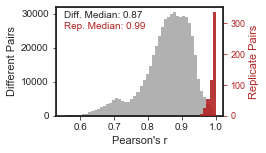

In [6]:
sns.set_style('ticks')

rand_color = 'darkgray'
rep_color = 'firebrick'

rep_median = np.median(rep_corrs)
rand_median = np.median(rand_corrs)

fig, ax = plt.subplots(figsize=(3,2))
ax2 = ax.twinx()
ax.hist(rand_corrs,bins=50,range=(0.55,1),alpha=0.9,color=rand_color,linewidth=0)
ax2.hist(rep_corrs,bins=50,range=(0.55,1),alpha=0.9,color=rep_color,linewidth=0)
ax.set_xlabel("Pearson's r",fontsize=11)
#ax.set_xticks(np.arange(0.4, 1.1, 0.1))
ax.set_ylabel('Different Pairs',fontsize=11)
ax.tick_params(axis='y', labelsize=10)
ax2.set_ylabel('Replicate Pairs',fontsize=11, color=rep_color)
ax2.tick_params(axis='y', colors=rep_color, labelsize=9)
ax.text(0.05, 0.9, f'Diff. Median: {rand_median:.2f}', transform=ax.transAxes, fontsize=10)
ax.text(0.05, 0.80, f'Rep. Median: {rep_median:.2f}', transform=ax.transAxes, color=rep_color, fontsize=10)
for s in ax.spines.values():
    s.set_color('black')
    s.set_linewidth(1.5)
plt.savefig(os.path.join(FIG_PATH, 'replicate_correlations.svg'), bbox_inches='tight', dpi=400)
plt.savefig(os.path.join(FIG_PATH, 'replicate_correlations.png'), bbox_inches='tight', dpi=400)

# DEGs

Determine numbers of DEGs across conditions

In [41]:
cond_pair_to_deg_count = {}
for deg_file in tqdm(os.listdir(DEG_PATH)):
    # ensure we're dealing with a CSV
    if '.csv' in deg_file:
        deg_df = pd.read_csv(os.path.join(DEG_PATH, deg_file), index_col=0)
        # only accept adjusted p-values below 0.01 and larger log-fold changes
        sig_deg_df = deg_df[(deg_df['padj'] < 0.01) & (deg_df['log2FoldChange'].abs() > 1.5)]
        n_degs = sig_deg_df.shape[0]
        full_name_1, full_name_2 = [cond.replace('__', ':') for cond in deg_file.split('.')[0].split('_vs_')]
        cond_pair_to_deg_count[(full_name_1, full_name_2)] = n_degs

  0%|          | 0/6104 [00:00<?, ?it/s]

### High-Low Investigation

In [42]:
sorted_deg_conds_hi_low = sorted(cond_pair_to_deg_count.items(), key=lambda tup: tup[1], reverse=True)
sorted_deg_conds_hi_low[:100]

[(('minicoli:minE_glyc', 'minicoli:W3110_LB'), 2407),
 (('minicoli:minE-pyr', 'minicoli:W3110_LB'), 2386),
 (('minicoli:mg1655_glc', 'minicoli:minE_glyc'), 2361),
 (('minicoli:minE_glyc', 'minicoli:W3110_cyt'), 2355),
 (('minicoli:mg1655_glc', 'minicoli:minE-pyr'), 2345),
 (('minicoli:minE_glyc', 'minicoli:W3110_WT_glc'), 2345),
 (('minicoli:minE-pyr', 'minicoli:W3110_N_starve'), 2333),
 (('minicoli:minE-pyr', 'minicoli:W3110_WT_glc'), 2327),
 (('minicoli:minE-pyr', 'minicoli:W3110_cyt'), 2322),
 (('minicoli:minE_glyc', 'minicoli:W3110_N_starve'), 2322),
 (('minicoli:minE_glyc', 'minicoli:W3110_glc'), 2322),
 (('minicoli:minE_glyc', 'minicoli:W3110_osm'), 2285),
 (('minicoli:minE_glyc', 'minicoli:W3110_WT_osm'), 2282),
 (('minicoli:minE-pyr', 'minicoli:W3110_ph5'), 2282),
 (('minicoli:minE-pyr', 'minicoli:W3110_glc'), 2281),
 (('minicoli:minE_glyc', 'minicoli:W3110_sorb'), 2262),
 (('minicoli:minE_glyc', 'minicoli:W3110_ph5'), 2261),
 (('minicoli:minE-pyr', 'minicoli:W3110_osm'), 2252)

In [43]:
sorted_deg_conds_low_hi = sorted(cond_pair_to_deg_count.items(), key=lambda tup: tup[1])
sorted_deg_conds_low_hi[:100]

[(('rpoB:rpoBE546V_031', 'rpoB:rpoBE546V_044'), 0),
 (('DDB2:PD-003_del-phoB_Fed-batch_6h', 'DDB2:PD-005_del-phoB_Fed-batch_6h'),
  0),
 (('pcoli:ggAANAT', 'pcoli:ocAANAT'), 0),
 (('svns_pgi:BmePgi24_26', 'svns_pgi:BmePgi24_52'), 0),
 (('ros_tale:7_103_250pq', 'ros_tale:7_103_750pq'), 0),
 (('cck_sdh:sdh_ale1', 'cck_sdh:sdh_ale2'), 0),
 (('cck_sdh:sdh_ale1', 'cck_sdh:sdh_ale3'), 0),
 (('pcoli:hsTPH_E2K', 'pcoli:hsTPH_N174trunc'), 0),
 (('cck_sdh:sdh_ale2', 'cck_sdh:sdh_ale3'), 0),
 (('DDB2:PD-003_del-qseF_Fed-batch_6h', 'DDB2:PD-005_del-qseF_Fed-batch_6h'),
  0),
 (('ros_tale:29_119_250pq', 'ros_tale:29_119_750pq'), 0),
 (('pcoli:btAANAT', 'pcoli:hsTPH_N174trunc'), 1),
 (('eep:BOP27_nuoB-cyoB_A9_F63_I1_R1', 'eep:BOP27_nuoB-cyoB_A10_F64_I1_R1'),
  1),
 (('cck_gnd:gnd_ale1', 'cck_gnd:gnd_ale3'), 1),
 (('acid_tale:MES_ale_pH7', 'acid_tale:gmos_pH7'), 1),
 (('DDB2:PD-005_BW25113_Fed-batch_6h', 'DDB2:PD-005_del-phoB_Fed-batch_6h'),
  1),
 (('DDB3:PD-009_del-lsrK_Fed-batch_6h', 'DDB3:PD-009_

### Histogram

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


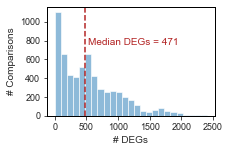

In [44]:
sns.set_style('ticks')

_, ax = plt.subplots(figsize=(3, 2))

sns.histplot(cond_pair_to_deg_count.values(), color='steelblue', bins=25, ax=ax)

ax.legend().set_visible(False)
ax.tick_params(axis='both', labelsize=9)
ax.set_xlabel('# DEGs', fontsize=10)
ax.set_ylabel('# Comparisons')

median_degs = np.median(list(cond_pair_to_deg_count.values()))
ax.axvline(median_degs, linestyle='--', color='firebrick')
ax.text(median_degs + 50, 750, f'Median DEGs = {median_degs:.0f}', color='firebrick', fontsize=10)

for s in ax.spines.values():
    s.set_color('black')
    s.set_linewidth(1)
    
plt.savefig(os.path.join(FIG_PATH, 'degs_histogram.svg'), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join(FIG_PATH, 'degs_histogram.png'), dpi=400, bbox_inches='tight')

# PCA

In [7]:
pca = PCA()
DF_weights = pd.DataFrame(pca.fit_transform(log_tpm.T), index=log_tpm.columns)
DF_components = pd.DataFrame(pca.components_.T, index=log_tpm.index)

## Explained Variance

Number of dimensions for 95% of variance: 135


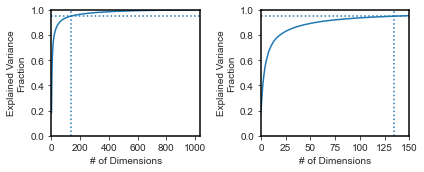

In [8]:
# Set the explained variance threshold
var_cutoff = 0.95

fig, (ax_all, ax_close) = plt.subplots(1, 2, figsize=(6,2.5))
pca_var = np.cumsum(pca.explained_variance_ratio_)
ax_all.plot(pca_var)
dims = np.where(pca_var > var_cutoff)[0][0] + 1
ax_all.vlines(dims,0,1,linestyles='dotted')
ax_all.hlines(var_cutoff,0,len(log_tpm.columns),linestyles='dotted')
ax_all.set_ylim(0,1)
ax_all.set_xlim(0,len(log_tpm.columns))
ax_all.set_ylabel('Explained Variance\nFraction',fontsize=10)
ax_all.set_xlabel('# of Dimensions',fontsize=10)
ax_all.set_xticks(np.arange(0, 1100, 200))
for s in ax_all.spines.values():
    s.set_color('black')
    s.set_linewidth(1.5)
    
ax_close.plot(pca_var)
dims = np.where(pca_var > var_cutoff)[0][0] + 1
ax_close.vlines(dims,0,1,linestyles='dotted')
ax_close.hlines(var_cutoff,0,len(log_tpm.columns),linestyles='dotted')
ax_close.set_ylim(0,1)
ax_close.set_xlim(0,150)
ax_close.set_ylabel('Explained Variance\nFraction',fontsize=10)
ax_close.set_xlabel('# of Dimensions',fontsize=10)
ax_close.set_xticks(np.arange(0, 160, 25))
for s in ax_close.spines.values():
    s.set_color('black')
    s.set_linewidth(1.5)
print(f'Number of dimensions for {var_cutoff*100:.0f}% of variance:', dims)
plt.tight_layout()

## First 2 Components: By Study

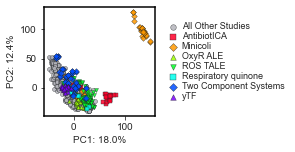

In [9]:
show_study = []
study_sort = []
for exp_id in p1k_sample_table.index:
    if p1k_sample_table.loc[exp_id, 'study'] in ['AntibiotICA', 'ROS TALE', 'Respiratory quinone',
                                           'Two Component Systems', 'yTF',                                         
                                          'Minicoli', 'OxyR ALE']:
        show_study.append(p1k_sample_table.loc[exp_id, 'study'])
        study_sort.append(0)
    else:
        show_study.append('All Other Studies')
        study_sort.append(1)
        
p1k_sample_table['show_study'] = show_study
p1k_sample_table['study_sort'] = study_sort
p1k_sample_table = p1k_sample_table.sort_values(by = ['study_sort', 'show_study'], ascending = [False,True])

NUM_COLORS = len(p1k_sample_table.groupby('show_study')) 
cm = pylab.get_cmap('gist_rainbow')
colors = ['#B4B4BB']+[cm(1.*i/(NUM_COLORS-1)) for i in range(0,NUM_COLORS-1)]
marker_list = ["o", "s", "D", "^", "v","s", "D", "^", "v", "s", "D", "^", "v","s", "D", "^", "v"]
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels

fig,ax = plt.subplots(figsize=(2,2))

for s in ax.spines.values():
    s.set_color('black')
    s.set_linewidth(1.5)

for i,(name,group) in enumerate(p1k_sample_table.groupby('show_study', sort=False)):
    idx = log_tpm.loc[:,group.index.tolist()].columns.tolist()
    ax.scatter(DF_weights.loc[idx,0],
               DF_weights.loc[idx,1],
               label=name,alpha=0.85, color=colors[i],marker=marker_list[i], s=16, linewidths =.4, edgecolors='#1C2021')
ax.set_xlabel('PC1: %.1f%%'%(pca.explained_variance_ratio_[0]*100),fontsize=10)
ax.set_ylabel('PC2: %.1f%%'%(pca.explained_variance_ratio_[1]*100),fontsize=10)
plt.legend(bbox_to_anchor=(1,0.5),loc='center left',fontsize=9,ncol=1, markerscale=1.4, columnspacing=0.1, handletextpad=.01,
          frameon=False, labelspacing=0.11)
plt.savefig(os.path.join(FIG_PATH, 'pca_components_study.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(os.path.join(FIG_PATH, 'pca_components_study.png'), dpi = 600, bbox_inches = 'tight')

## First 2 Components: By Creator

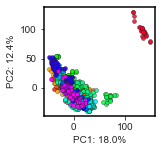

In [10]:
NUM_COLORS = len(p1k_sample_table.groupby('creator')) 
cm = pylab.get_cmap('gist_rainbow')
colors = ['#B4B4BB']+[cm(1.*i/(NUM_COLORS-1)) for i in range(0,NUM_COLORS-1)]
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels

fig,ax = plt.subplots(figsize=(2,2))

for s in ax.spines.values():
    s.set_color('black')
    s.set_linewidth(1.5)

for i, (creator,creator_group) in enumerate(p1k_sample_table.groupby('creator')):
    idx = log_tpm.loc[:,creator_group.index.tolist()].columns.tolist()
    ax.scatter(DF_weights.loc[idx,0],
               DF_weights.loc[idx,1],
               label=name,alpha=0.85, color=colors[i],s=16, linewidths =.4, edgecolors='#1C2021')
ax.set_xlabel('PC1: %.1f%%'%(pca.explained_variance_ratio_[0]*100),fontsize=10)
ax.set_ylabel('PC2: %.1f%%'%(pca.explained_variance_ratio_[1]*100),fontsize=10)
plt.savefig(os.path.join(FIG_PATH, 'pca_components_creator.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(os.path.join(FIG_PATH, 'pca_components_creator.png'), dpi = 600, bbox_inches = 'tight')

## w/o Minicoli

In [11]:
p1k_sample_table_no_mc = p1k_sample_table[p1k_sample_table['study'] != 'Minicoli'].copy()
log_tpm_no_mc = log_tpm[p1k_sample_table_no_mc.index]

pca_no_mc = PCA()
DF_weights_no_mc = pd.DataFrame(pca_no_mc.fit_transform(log_tpm_no_mc.T), index=log_tpm_no_mc.columns)
DF_components_no_mc = pd.DataFrame(pca_no_mc.components_.T, index=log_tpm_no_mc.index)

Number of dimensions for 95% of variance: 153


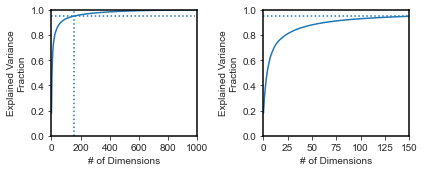

In [12]:
# Set the explained variance threshold
var_cutoff = 0.95

fig, (ax_all, ax_close) = plt.subplots(1, 2, figsize=(6,2.5))
pca_var = np.cumsum(pca_no_mc.explained_variance_ratio_)
ax_all.plot(pca_var)
dims = np.where(pca_var > var_cutoff)[0][0] + 1
ax_all.vlines(dims,0,1,linestyles='dotted')
ax_all.hlines(var_cutoff,0,len(log_tpm_no_mc.columns),linestyles='dotted')
ax_all.set_ylim(0,1)
ax_all.set_xlim(0,len(log_tpm_no_mc.columns))
ax_all.set_ylabel('Explained Variance\nFraction',fontsize=10)
ax_all.set_xlabel('# of Dimensions',fontsize=10)
ax_all.set_xticks(np.arange(0, 1100, 200))
for s in ax_all.spines.values():
    s.set_color('black')
    s.set_linewidth(1.5)
    
ax_close.plot(pca_var)
dims = np.where(pca_var > var_cutoff)[0][0] + 1
ax_close.vlines(dims,0,1,linestyles='dotted')
ax_close.hlines(var_cutoff,0,len(log_tpm_no_mc.columns),linestyles='dotted')
ax_close.set_ylim(0,1)
ax_close.set_xlim(0,150)
ax_close.set_ylabel('Explained Variance\nFraction',fontsize=10)
ax_close.set_xlabel('# of Dimensions',fontsize=10)
ax_close.set_xticks(np.arange(0, 160, 25))
for s in ax_close.spines.values():
    s.set_color('black')
    s.set_linewidth(1.5)
print(f'Number of dimensions for {var_cutoff*100:.0f}% of variance:', dims)
plt.tight_layout()

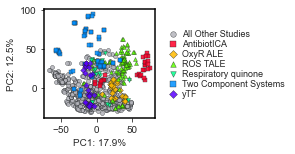

In [13]:
show_study = []
study_sort = []
for exp_id in p1k_sample_table_no_mc.index:
    if p1k_sample_table_no_mc.loc[exp_id, 'study'] in ['AntibiotICA', 'ROS TALE', 'Respiratory quinone',
                                           'Two Component Systems', 'yTF',                                         
                                          'Minicoli', 'OxyR ALE']:
        show_study.append(p1k_sample_table_no_mc.loc[exp_id, 'study'])
        study_sort.append(0)
    else:
        show_study.append('All Other Studies')
        study_sort.append(1)
        
p1k_sample_table_no_mc['show_study'] = show_study
p1k_sample_table_no_mc['study_sort'] = study_sort
p1k_sample_table_no_mc = p1k_sample_table_no_mc.sort_values(by = ['study_sort', 'show_study'], ascending = [False,True])

NUM_COLORS = len(p1k_sample_table_no_mc.groupby('show_study')) 
cm = pylab.get_cmap('gist_rainbow')
colors = ['#B4B4BB']+[cm(1.*i/(NUM_COLORS-1)) for i in range(0,NUM_COLORS-1)]
marker_list = ["o", "s", "D", "^", "v","s", "D", "^", "v", "s", "D", "^", "v","s", "D", "^", "v"]
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels

fig,ax = plt.subplots(figsize=(2,2))

for s in ax.spines.values():
    s.set_color('black')
    s.set_linewidth(1.5)

for i,(name,group) in enumerate(p1k_sample_table_no_mc.groupby('show_study', sort=False)):
    idx = log_tpm_no_mc.loc[:,group.index.tolist()].columns.tolist()
    ax.scatter(DF_weights_no_mc.loc[idx,0],
               DF_weights_no_mc.loc[idx,1],
               label=name,alpha=0.85, color=colors[i],marker=marker_list[i], s=16, linewidths =.4, edgecolors='#1C2021')
ax.set_xlabel('PC1: %.1f%%'%(pca_no_mc.explained_variance_ratio_[0]*100),fontsize=10)
ax.set_ylabel('PC2: %.1f%%'%(pca_no_mc.explained_variance_ratio_[1]*100),fontsize=10)
plt.legend(bbox_to_anchor=(1,0.5),loc='center left',fontsize=9,ncol=1, markerscale=1.4, columnspacing=0.1, handletextpad=.01,
          frameon=False, labelspacing=0.11)
plt.savefig(os.path.join(FIG_PATH, 'pca_components_study_no_minicoli.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(os.path.join(FIG_PATH, 'pca_components_study_no_minicoli.png'), dpi = 600, bbox_inches = 'tight')

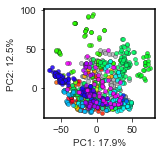

In [14]:
NUM_COLORS = len(p1k_sample_table_no_mc.groupby('creator')) 
cm = pylab.get_cmap('gist_rainbow')
colors = ['#B4B4BB']+[cm(1.*i/(NUM_COLORS-1)) for i in range(0,NUM_COLORS-1)]
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels

fig,ax = plt.subplots(figsize=(2,2))

for s in ax.spines.values():
    s.set_color('black')
    s.set_linewidth(1.5)

for i, (creator,creator_group) in enumerate(p1k_sample_table_no_mc.groupby('creator')):
    idx = log_tpm_no_mc.loc[:,creator_group.index.tolist()].columns.tolist()
    ax.scatter(DF_weights_no_mc.loc[idx,0],
               DF_weights_no_mc.loc[idx,1],
               label=name,alpha=0.85, color=colors[i],s=16, linewidths =.4, edgecolors='#1C2021')
ax.set_xlabel('PC1: %.1f%%'%(pca_no_mc.explained_variance_ratio_[0]*100),fontsize=10)
ax.set_ylabel('PC2: %.1f%%'%(pca_no_mc.explained_variance_ratio_[1]*100),fontsize=10)
plt.savefig(os.path.join(FIG_PATH, 'pca_components_creator_no_minicoli.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(os.path.join(FIG_PATH, 'pca_components_creator_no_minicoli.png'), dpi = 600, bbox_inches = 'tight')

# Gene Expression Breakdowns

## Load Gene Table

In [15]:
gene_table = pd.read_csv(os.path.join(ANNOTATION_PATH, 'gene_info.csv'), index_col=0)

### Add in_iM Column

Only to be run once

In [21]:
genes_in_im = []
for im in p1k.imodulon_names:
    genes_in_im.extend(list(p1k.view_imodulon(im).index))
genes_in_im = list(set(genes_in_im))

gene_table = gene_table.assign(
    in_iM=gene_table.apply(lambda row: row.name in genes_in_im, axis=1)
)

In [22]:
gene_table.to_csv(os.path.join(ANNOTATION_PATH, 'gene_info.csv'))

In [23]:
p1k.gene_table = gene_table

In [24]:
save_to_json(p1k, os.path.join(P1K_PATH, 'precise1k'), compress=True)

### Select Only Final P1K Genes

In [16]:
gene_table_p1k = gene_table[gene_table['p1k']]
gene_table_p1k.head()

,gene_name,synonyms,gene_product,COG,regulator,uniprot,start,end,strand,essential,...,y_ome,k_eff,schmidt_prot_med,heckmann_prot_med,proteomics,p1k,p1k_ctrl_log_tpm,p1k_median_log_tpm,p1k_mad_log_tpm,in_iM
locus_tag,,,,,,,,,,,,,,,,,,,,,
b0002,thrA,thrA;thrA1;thrA2,fused aspartate kinase/homoserine dehydrogenase 1,Amino acid transport and metabolism,"RpoD,Ile-tRNA,Thr-tRNA,DksA,Fnr,ArcA,ppGpp",P00561,337,2799,+,False,...,False,True,4101.5,4434.0,True,True,10.314562,9.605329,1.042143,True
b0003,thrB,thrB,homoserine kinase,Nucleotide transport and metabolism,"RpoD,Ile-tRNA,Thr-tRNA,DksA,ppGpp",P00547,2801,3733,+,False,...,False,True,442.0,1177.0,True,True,9.982251,9.232803,1.035654,True
b0004,thrC,thrC,threonine synthase,Amino acid transport and metabolism,"RpoD,ppGpp,Ile-tRNA,Thr-tRNA,DksA",P00934,3734,5020,+,False,...,False,True,8818.5,3516.0,True,True,9.973666,9.274271,0.906287,True
b0005,yaaX,yaaX,DUF2502 domain-containing protein YaaX,Function unknown,Lrp,P75616,5234,5530,+,False,...,True,False,NaN,NaN,False,True,7.132482,6.283661,1.093146,True
b0006,yaaA,yaaA,peroxide stress resistance protein YaaA,Function unknown,NaN,P0A8I3,5683,6459,-,False,...,True,True,539.5,333.0,True,True,6.494941,6.346626,0.454519,True


## Statistical Comparisons

Running Mann-Whitney U tests for the medians of categories plotted below

In [17]:
cols = ['in_iM', 'iML1515', 'y_ome', 'proteomics', 'core_genome']

stats_df = pd.DataFrame(columns=['n_yes', 'n_no', 'U', 'P', 'U_mad', 'P_mad'])

for col in cols:
    yes_log_tpm_meds = gene_table_p1k[gene_table_p1k[col]]['p1k_median_log_tpm'].values
    no_log_tpm_meds = gene_table_p1k[~gene_table_p1k[col]]['p1k_median_log_tpm'].values
    n_yes = len(yes_log_tpm_meds)
    n_no = len(no_log_tpm_meds)
    U, p = mannwhitneyu(yes_log_tpm_meds, no_log_tpm_meds)
    yes_log_tpm_mads = gene_table_p1k[gene_table_p1k[col]]['p1k_mad_log_tpm'].values
    no_log_tpm_mads = gene_table_p1k[~gene_table_p1k[col]]['p1k_mad_log_tpm'].values
    U_mad, p_mad = mannwhitneyu(yes_log_tpm_mads, no_log_tpm_mads)
    stats_df.loc[col] = [n_yes, n_no, U, p, U_mad, p_mad]
    
stats_df

,n_yes,n_no,U,P,U_mad,P_mad
in_iM,2485.0,1772.0,2159090.0,2.809425e-01,3452234.5,1.172779e-219
iML1515,1511.0,2746.0,2400953.5,1.811482e-17,2239728.0,1.681583e-05
y_ome,1473.0,2784.0,1348073.0,1.052786e-75,2186367.5,3.652856e-04
proteomics,2031.0,2226.0,4010646.0,0.000000e+00,2237998.0,5.742013e-01
core_genome,356.0,3901.0,1178166.0,2.666801e-105,516214.0,1.007869e-15


## Function: plot_expression_by_boolean_category

In [18]:
sns.set_style('whitegrid')

def plot_jointgrid(genes, color, title, filename):
    g = sns.JointGrid(data=gene_table_p1k.loc[genes], x='p1k_median_log_tpm',y='p1k_mad_log_tpm',
                      xlim=(0, 15), ylim=(0, 4),
                      height=1.75, marginal_ticks=False)
    g.plot_joint(sns.histplot, color=color, bins=25)
    g.plot_marginals(sns.boxplot, color=color, fliersize=0.5, linewidth=0.5)

    g.ax_joint.set_xlabel('Median log[TPM]', fontsize=8)
    g.ax_joint.set_ylabel('MAD log[TPM]', fontsize=8)
    g.ax_joint.set_xticks(np.arange(0, 20, 5))
    for s in g.ax_joint.spines.values():
        s.set_visible(True)
        s.set_color('k')
        s.set_linewidth(0.9)
        
    g.ax_marg_x.set_title(f'{title} (n={len(genes)})', fontsize=10)

    for s in (list(g.ax_marg_x.spines.values()) + list(g.ax_marg_y.spines.values())):
        s.set_visible(False)
        
    plt.savefig(os.path.join(FIG_PATH, f'{filename}.png'), bbox_inches='tight', dpi=400)
    plt.savefig(os.path.join(FIG_PATH, f'{filename}.svg'), bbox_inches='tight', dpi=400)

def plot_expression_by_boolean_category(bool_col, filename_prefix, title_base, title_negate='not'):
    
    # get the yes/no genes from the category column
    yes_genes = gene_table_p1k[gene_table_p1k[bool_col]].index
    no_genes = gene_table_p1k[~gene_table_p1k[bool_col]].index
    
    plot_jointgrid(yes_genes, 'steelblue', title_base, f'{filename_prefix}_yes')
    plot_jointgrid(no_genes, 'firebrick', f'{title_negate} {title_base}', f'{filename_prefix}_no')

## iModulon Membership

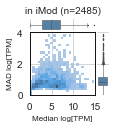

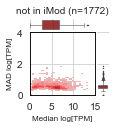

In [19]:
plot_expression_by_boolean_category('in_iM', 'im_membership', 'in iMod')

## iML1515

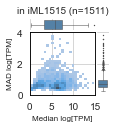

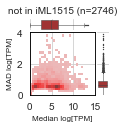

In [20]:
plot_expression_by_boolean_category('iML1515', 'iML1515', 'in iML1515')

## y-ome

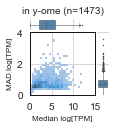

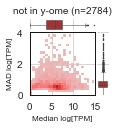

In [21]:
plot_expression_by_boolean_category('y_ome', 'y_ome', 'in y-ome')

### y-ome Fraction in iModulon

In [22]:
n_im_yome = gene_table_p1k[gene_table_p1k['in_iM'] & gene_table_p1k['y_ome']].shape[0]
n_yome = gene_table_p1k[gene_table_p1k['y_ome']].shape[0]
print(f'{n_im_yome}/{n_yome} ({n_im_yome/n_yome*100:.1f})% of y-ome in at least 1 iModulon')

823/1473 (55.9)% of y-ome in at least 1 iModulon


## Proteomics

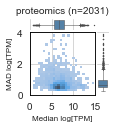

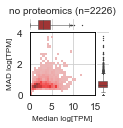

In [23]:
plot_expression_by_boolean_category('proteomics', 'proteomics', 'proteomics', title_negate='no')

## Core Genome

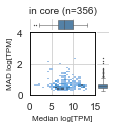

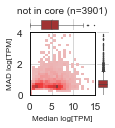

In [24]:
plot_expression_by_boolean_category('core_genome', 'core_genome', 'in core')

### by COG category

In [25]:
gene_table_p1k['COG'].value_counts()

Function unknown                                                    834
Transcription                                                       377
Amino acid transport and metabolism                                 311
Inorganic ion transport and metabolism                              305
Energy production and conversion                                    291
Cell wall/membrane/envelope biogenesis                              269
Translation, ribosomal structure and biogenesis                     244
Nucleotide transport and metabolism                                 242
Carbohydrate transport and metabolism                               239
Replication, recombination and repair                               228
No COG annotation                                                   160
Post-translational modification, protein turnover,and chaperones    123
Coenzyme transport and metabolism                                   122
Cell motility                                                   

In [26]:
gene_table_p1k[gene_table_p1k['core_genome']]['COG'].value_counts()

Translation, ribosomal structure and biogenesis                     152
Nucleotide transport and metabolism                                  41
Amino acid transport and metabolism                                  36
Coenzyme transport and metabolism                                    29
Lipid transport and metabolism                                       26
Energy production and conversion                                     18
Cell wall/membrane/envelope biogenesis                               16
Transcription                                                        14
Function unknown                                                      6
Post-translational modification, protein turnover,and chaperones      5
Inorganic ion transport and metabolism                                4
Carbohydrate transport and metabolism                                 2
Cell cycle control, cell division, chromosome partitioning            2
Intracellular trafficking, secretion, and vesicular transport   

## COG

In [37]:
cog_short_lookup = {
    'Translation, ribosomal structure and biogenesis': 'Translation',
    'Cell cycle control, cell division, chromosome partitioning': 'Cell cycle',
    'Nucleotide transport and metabolism': 'Nucleotide metabolism',
    'Post-translational modification, protein turnover,and chaperones': 'Post-translational modification',
    'Coenzyme transport and metabolism': 'Coenzyme metabolism',
    'Cell wall/membrane/envelope biogenesis': 'Cell wall/membrane/envelope biogenesis',
    'Amino acid transport and metabolism': 'Amino acid metabolism',
    'Secondary metabolites biosynthesis, transport, and catabolism': 'Secondary metabolites',
    'Transcription': 'Transcription',
    'Function unknown': 'Unknown',
    'Replication, recombination and repair': 'Replication, recombination, and repair',
    'RNA processing and modification': 'RNA processing',
    'Lipid transport and metabolism': 'Lipid metabolism',
    'Signal transduction mechanisms': 'Signal transduction',
    'Defense mechanisms': 'Defense mechanisms',
    'Intracellular trafficking, secretion, and vesicular transport': 'Intracellular trafficking and secretion',
    'Inorganic ion transport and metabolism': 'Inorganic ion metabolism',
    'Energy production and conversion': 'Energy production',
    'Carbohydrate transport and metabolism': 'Carbohydrate metabolism',
    'No COG annotation': 'No COG annotation',
    'Cell motility': 'Cell motility'
}

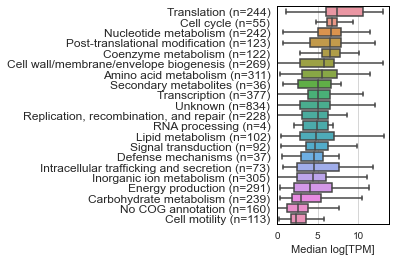

In [40]:
sns.set_style('whitegrid')
_, ax = plt.subplots(figsize=(2, 4))
sns.boxplot(y='COG', x='p1k_median_log_tpm', data=gene_table_p1k,
            order=gene_table_p1k.groupby('COG').median().sort_values('p1k_median_log_tpm', ascending=False).index,
            orient='h', showfliers=False,
           ax=ax)

ax.set_xlabel('Median log[TPM]', fontsize=11)
ax.set_ylabel('')
ax.set_xlim(0, ax.get_xlim()[1])
old_labs = [t.get_text() for t in ax.get_yticklabels()]
new_labs = [
    f"{cog_short_lookup[cog]} (n={gene_table_p1k[gene_table_p1k['COG'] == cog].shape[0]})"
    for cog in old_labs
]
ax.set_yticklabels(new_labs)
ax.tick_params(axis='y', labelsize=12)

for s in ax.spines.values():
    s.set_linewidth(1)
    s.set_color('k')
    
plt.savefig(os.path.join(FIG_PATH, 'by_cog.png'), bbox_inches='tight', dpi=400)
plt.savefig(os.path.join(FIG_PATH, 'by_cog.svg'), bbox_inches='tight', dpi=400)